In [1]:
# # header
import sys
sys.path.append(r"../")

%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
from src.model import AttentionModel
from src.composer import PsychGrating
from src.conductor import seq_cls_eval
from src.utils import plot_all, build_loaders, sigmoid, fit_sigmoid
from prelude import get_device, startup_folders, load_dicts
import matplotlib.pyplot as plt

In [ ]:
start_folder = r"../pretrained/psycphys/contrast"
results_folder, logger = startup_folders(start_folder, name=f"exp_a")
data_path = r"../data"

../results/psycphys/contrast/1753266056 was created!


In [4]:
model_params = load_dicts(start_folder, "model_params")
tasks = load_dicts(start_folder, "tasks")
train_params = load_dicts(start_folder, "train_params")
DeVice, num_workers, pin_memory = get_device()
print(f"model_params: {model_params}")
print(f"tasks: {tasks}")
print(f"train_params: {train_params}")
train_params["batch_size"] = 256
tasks

Device set to mps
model_params: {'in_dims': [1, 96, 96], 'n_classes': 9, 'out_dim': 9, 'normalize': True, 'softness': 0.5, 'channels': [1, 4, 8, 16, 32, 32], 'residuals': False, 'kernels': 3, 'strides': 2, 'paddings': 1, 'conv_bias': True, 'conv_norms': [None, 'layer', 'layer', 'layer', 'layer'], 'conv_dropouts': 0.0, 'conv_funs': ReLU(), 'deconv_funs': Tanh(), 'deconv_norms': [None, 'layer', 'layer', 'layer', 'layer'], 'pools': [1, 1, 1, 1, 1], 'rnn_dims': [16], 'rnn_bias': True, 'rnn_dropouts': 0.0, 'rnn_funs': ReLU(), 'n_tasks': 1, 'task_layers': 1, 'task_weight': True, 'task_bias': True, 'task_funs': Tanh(), 'norm_mean': [0.5], 'norm_std': [0.25], 'rnn_to_fc': False, 'trans_fun': Identity()}
tasks: {'RotationChangeDetection': {'composer': 'PsychGrating', 'key': 0, 'params': {'episodes': [0, 2, 0, 2], 'a_range': [0.0, 0.75], 'n_range': [0.0, 0.25], 'b_range': [0.0, 0.25], 'biased': 0.125, 'rot_noise': 0, 'cls_rot': False, 'force_range': False, 'force_label': False, 'force_cue': Fals

{'RotationChangeDetection': {'composer': 'PsychGrating',
  'key': 0,
  'params': {'episodes': [0, 2, 0, 2],
   'a_range': [0.0, 0.75],
   'n_range': [0.0, 0.25],
   'b_range': [0.0, 0.25],
   'biased': 0.125,
   'rot_noise': 0,
   'cls_rot': False,
   'force_range': False,
   'force_label': False,
   'force_cue': False,
   'force_loc': False,
   'gabor_cue': False,
   'show_cue': True,
   'decay_rate': 0.0},
  'datasets': ['PsychGrating', 'PsychGrating', 'PsychGrating'],
  'dataloaders': [None, None, None],
  'loss_w': [[1.0, 1.0], [1.0, 1.0]],
  'loss_s': [[-2, -1], [-4, -3]]}}

In [5]:
# datasets and dataloaders
o = "RotationChangeDetection"
tasks[o]["composer"] = PsychGrating
tasks[o]["datasets"] = []
tasks[o]["dataloaders"] = []

# datasets and dataloaders
for o in tasks:
    tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"], n_samples=train_params["n_samples"]))
    tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"], n_samples=1024))
    tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"], n_samples=1024))
    tasks[o]["dataloaders"] = build_loaders(tasks[o]["datasets"], batch_size=train_params["batch_size"], num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# create a blank model
model = AttentionModel(**model_params)

# load states into the model
model_dir = os.path.join(start_folder, "model" + ".pth")
assert os.path.exists(model_dir), "Could not find the model.pth in the given dir!"
model.load_state_dict(torch.load(model_dir, map_location=DeVice))

<All keys matched successfully>

In [6]:
ce_loss, accuracy, mask_loss = seq_cls_eval(model, tasks, DeVice, logger, valid=True, verbose=True)
print(f"CE Loss: {ce_loss}, Accuracy: {accuracy}, Mask Loss: {mask_loss}")

Validating...
	 -2 CE-Loss: 0.4144
	 -2 Acc: 0.8975
	 -1 CE-Loss: 0.3511
	 -1 Acc: 0.9141
	 -4 Mask MSE: 55.3269
	 -3 Mask MSE: 76.4571


CE Loss: [0.41441596299409866, 0.3510715290904045], Accuracy: [0.8974609375, 0.9140625], Mask Loss: [55.32694625854492, 76.45706558227539]


In [7]:
o = "RotationChangeDetection"
amp_range = torch.linspace(0.0, 0.5, 51).tolist()
# noise_range = torch.linspace(tasks[o]["params"]["n_range"][0], tasks[o]["params"]["n_range"][1], 6).tolist()
noise_range = (0.25,)
loc_range = (True, False, None)
base_range = 0.125
ce_stuff = torch.zeros(len(loc_range), len(noise_range), len(amp_range), len(tasks[o]["loss_s"][0]))
acc_stuff = torch.zeros(len(loc_range), len(noise_range), len(amp_range), len(tasks[o]["loss_s"][0]))
for b, bb in enumerate(loc_range):
    for n, nn in enumerate(noise_range):
        for a, aa in enumerate(amp_range):
            tasks[o]["dataloaders"][1].dataset.a_range = aa
            tasks[o]["dataloaders"][1].dataset.n_range = nn
            tasks[o]["dataloaders"][1].dataset.b_range = base_range
            tasks[o]["dataloaders"][1].dataset.biased = 0.125
            tasks[o]["dataloaders"][1].dataset.force_range = True
            tasks[o]["dataloaders"][1].dataset.force_label = True
            tasks[o]["dataloaders"][1].dataset.force_cue = True
            tasks[o]["dataloaders"][1].dataset.force_loc = bb if bb is not None else False
            tasks[o]["dataloaders"][1].dataset.cue_loc_off = True if bb is None else False 
            tasks[o]["dataloaders"][1].dataset.n_samples = 512
            tasks[o]["dataloaders"][1].dataset.show_cue = True
            ce_, acc_, mask_ = seq_cls_eval(model, tasks, DeVice, logger, valid=True, verbose=False)
            for i, _ in enumerate(tasks[o]["loss_s"][0]):
                ce_stuff[b][n][a][i] = ce_[i]
                acc_stuff[b][n][a][i] = acc_[i]
        plot_all(10, model, tasks, results_folder, f"_bb{bb}_nn{nn}_aa{aa}", DeVice, logger)

print(f"CE Stuff: {ce_stuff.shape}, Acc Stuff: {acc_stuff.shape}")
plot_all(10, model, tasks, results_folder, "_just_", DeVice, logger)

CE Stuff: torch.Size([3, 1, 51, 2]), Acc Stuff: torch.Size([3, 1, 51, 2])


Params for test-cued n0 - i-2: [ 1.44775545e+01  2.19391480e-01  1.03046334e+00 -1.40829973e-02]
Params for standard-cued n0 - i-2: [14.8015607   0.24972925  1.03130969 -0.01606291]


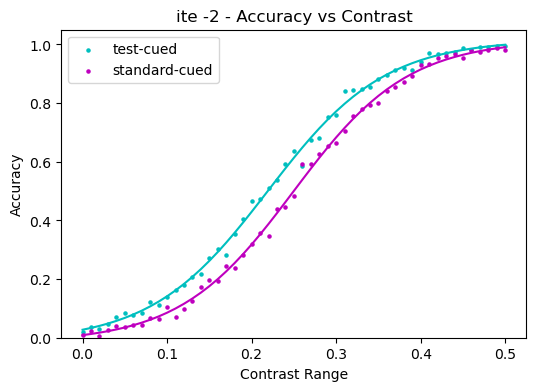

Params for test-cued n0 - i-1: [ 2.21042282e+01  1.65328946e-01  1.01129029e+00 -6.29006035e-03]
Params for standard-cued n0 - i-1: [ 2.09918914e+01  1.93676212e-01  1.01610877e+00 -7.97422934e-03]


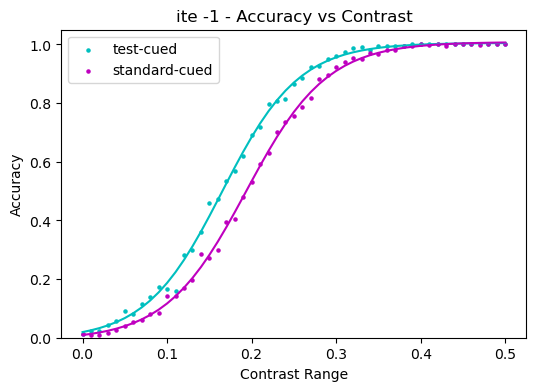

In [8]:
n = 0
x = torch.tensor(amp_range)
colors = ["c", "m", "y"]
for i in (-2, -1):
    plt.figure(figsize=(6, 4))
    plt.scatter(amp_range, acc_stuff[0, n, :, i], label=f"test-cued", color=colors[0], s=5)
    params = fit_sigmoid(x, acc_stuff[0, n, :, i])
    print(f"Params for test-cued n{n} - i{i}: {params}")
    y = sigmoid(x, *params)
    plt.plot(x, y, color=colors[0])
    plt.scatter(amp_range, acc_stuff[1, n, :, i], label=f"standard-cued", color=colors[1], s=5)
    params = fit_sigmoid(x, acc_stuff[1, n, :, i])
    print(f"Params for standard-cued n{n} - i{i}: {params}")
    y = sigmoid(x, *params)
    plt.plot(x, y, color=colors[1])
    # plt.scatter(amp_range, acc_stuff[2, n, :, i], label=f"neutral-cued", color=colors[2], s=5)
    # plt.plot(x, sigmoid(x, *fit_sigmoid(x, acc_stuff[2, n, :, i])), color=colors[2])
    plt.ylim(0.0, 1.05)
    plt.xlabel("Contrast Range")
    plt.ylabel("Accuracy")
    plt.title(f"ite {i} - Accuracy vs Contrast")
    plt.legend()
    plt.savefig(os.path.join(results_folder, f"s_ite{i}_noise{noise_range[n]}_acc_vs_contrast.svg"), format="svg")
    plt.show()
    

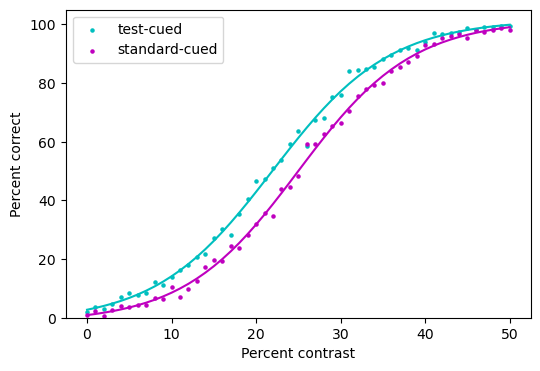

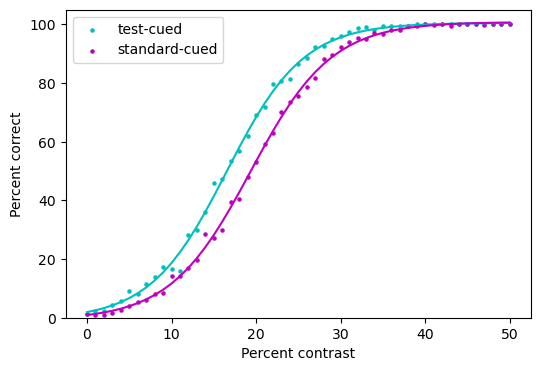

In [9]:
n = 0
x = torch.tensor(amp_range)
colors = ["c", "m", "y"]
for i in (-2, -1):
    plt.figure(figsize=(6, 4))
    plt.scatter(100*x, 100*acc_stuff[0, n, :, i], label=f"test-cued", color=colors[0], s=5)
    plt.plot(100*x, 100*sigmoid(x, *fit_sigmoid(x, acc_stuff[0, n, :, i])), color=colors[0])
    plt.scatter(100*x, 100*acc_stuff[1, n, :, i], label=f"standard-cued", color=colors[1], s=5)
    plt.plot(100*x, 100*sigmoid(x, *fit_sigmoid(x, acc_stuff[1, n, :, i])), color=colors[1])
    # plt.scatter(amp_range, acc_stuff[2, n, :, i], label=f"neutral-cued", color=colors[2], s=5)
    # plt.plot(x, sigmoid(x, *fit_sigmoid(x, acc_stuff[2, n, :, i])), color=colors[2])
    plt.ylim(0, 105)
    plt.xlabel("Percent contrast")
    plt.ylabel("Percent correct")
    # plt.title(f"ite {i} - Accuracy vs Contrast")
    plt.legend()
    plt.savefig(os.path.join(results_folder, f"s_ite{i}_noise{noise_range[n]}_acc_vs_contrast.svg"), format="svg")
    plt.show()
    

In [10]:
# for i in (-2, -1):
#     for k, r in enumerate(noise_range):
#         plt.plot(amp_range, acc_stuff[0, k, :, i], label=f"noise {r} (T-cued)", linestyle="--")
#         plt.plot(amp_range, acc_stuff[1, k, :, i], label=f"noise {r} ")
#         # plt.plot(amp_range, acc_stuff[2, k, :, i], label=f"noise {r} neutral", linestyle=":")
#     plt.xlabel("Contrast Range")
#     plt.ylabel("Accuracy")
#     plt.title(f"ite {i} - Accuracy vs Contrast")
#     plt.legend()
#     plt.savefig(os.path.join(results_folder, f"ite_{i}_acc_vs_contrast.svg"), format="svg")
#     plt.show()
    